<a href="https://colab.research.google.com/github/akavurga/Makine_Ogrenmesi_Uygulamalar/blob/main/%C5%9Eirket_Harcamalar%C4%B1_De%C4%9Ferlendirmesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Basit Random Forest Modeli Örneği
  * Veri Setinin Hikayesi : 50 Startup ın yaptığı harcamalar ve elde ettikleri kazançlar tutuluyor. Biz de bir startup olarak bu veri setinden neler çıkarabiliriz bakalım
  * Data içerisindeki R&D Spend : Şirketin Ar-Ge harcamaları , 
  * Administration : Şirketin Yönetimsel harcamlar,
  * Marketing Spend : Şirketin Reklam harcamları,
  * State: Şirketin bulunduğu eyalet,
  * Profit : Şirketin kârını ifade ediyor
  * Bağımlı değişken :  Profit



## Colab'e Bağlanalım

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import os
os.chdir("/gdrive/MyDrive/Colab Çalışma Ortamı")

## Datanın yüklenmesi

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

data = pd.read_csv("50_Startups.csv")
df = data.copy()
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


### Keşifçi Veri Analizi

In [ ]:
df.describe().T # Görünüşe göre Pazarlamaya ve Ar Ge ye hiç harcama yapmayan startuplar var muhtemelen en düşük kârı elde edenler de o startuplardır

,count,mean,std,min,25%,50%,75%,max
R&D Spend,50.0,73721.6156,45902.256482,0.00,39936.3700,73051.080,101602.8000,165349.20
Administration,50.0,121344.6396,28017.802755,51283.14,103730.8750,122699.795,144842.1800,182645.56
Marketing Spend,50.0,211025.0978,122290.310726,0.00,129300.1325,212716.240,299469.0850,471784.10
Profit,50.0,112012.6392,40306.180338,14681.40,90138.9025,107978.190,139765.9775,192261.83


In [ ]:
df.value_counts().sum()  # Ne kadar verim var ?

50

In [ ]:
df.shape  # Veri setim 50 satır ve 5 sütun(değişken) dan oluşuyor

(50, 5)

In [ ]:
df.isnull().sum()  # Acaba veri setimde Null değer var mı ?

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

In [ ]:
df.groupby('State').mean() # Eyaletlere göre harcamalar ve kâr ortalamaları. Görünüşe göre Floridalı startuplar ar ge ye gerçekten önem veriyorlar 

,R&D Spend,Administration,Marketing Spend,Profit
State,,,,
California,64657.674118,120746.507059,182540.929412,103905.175294
Florida,80724.016250,121768.897500,247323.551250,118774.024375
New York,76195.062353,121543.470588,205346.015882,113756.446471


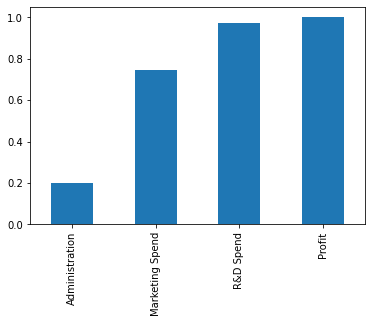

In [ ]:
df.corr()['Profit'].sort_values().plot(kind="bar"); # kârla harcamalar arasında ki kolerasyonu görelim. Görünüşe göre kârı en çok etkileyen harcamalar ar ge harcamalarıymış

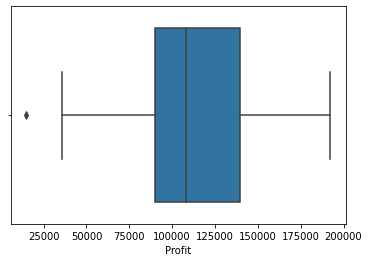

In [ ]:
sns.boxplot(x="Profit",data=df)  #Boxplot yöntemi ile Outlier değer var mı diye kontrol ediyorum 1 tane varmış, herhangi bir düzenlileştirme işlemi uygulamayacağım

## Veriyi Anladığımıza Göre Modelimizi Oluşturabiliriz

In [ ]:
# Gerekli Kütüphaleri İmport Edelim
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Veri Setindeki Kategorik Değişkenleri Makine Öğrenmesi Algoritmasının Anlayabileceği Bir Yapıya Sokalım. Burada One Hat Encoding yaklaşımını uygulayacağız.

df = pd.get_dummies(df, columns = ["State"],prefix=["State"])
df.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


In [ ]:
# Bağımlı ve Bağımız Değişkenlerimizi Belirleyip Train-Test Split Uygulayalım
y= df["Profit"]
X = df.drop(['Profit'],axis=1).astype('float64')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
# Modelimizi Oluşturalım

rf_model = RandomForestRegressor(random_state=42).fit(X_train,y_train)

In [ ]:
# İlkel Test Hatamızı Kontrol Edelim

y_pred = rf_model.predict(X_test)
print("r2_score = ",r2_score(y_test,y_pred),"hata kareleri ortalaması = ", np.sqrt(mean_squared_error(y_test,y_pred))) # Random forest modelimiz ilkel olarak %93 doğrulukla tahminde bulunabilir

r2_score =  0.9329041592010969 hata kareleri ortalaması =  8491.880839314812


In [ ]:
# Modelimizin Hiperparametrelerini GridSearchVC ile Optimize Edelim (Parametreleri rastgele deneyebilirsiniz, cv=3 değerini arttırabilirsiniz)

rf_params ={"max_depth":[5,8,10],"max_features":[2,5,10],"n_estimators":[200,500,1000,2000],"min_samples_split":[2,10,80,100]}

rf_cv_model = GridSearchCV(rf_model,rf_params,cv=3,n_jobs=-1).fit(X_train,y_train)

rf_cv_model.best_params_

{'max_depth': 10,
 'max_features': 5,
 'min_samples_split': 2,
 'n_estimators': 1000}

## Optimize Edilmiş (Tune Edilmiş) Model

In [ ]:
# Bulduğumuz En İyi Parametre Değerleri İle Yeni Modelimizi Oluşturalım

rf_tuned=RandomForestRegressor(random_state=42,max_depth=10,max_features=5,min_samples_split=2,n_estimators=1000).fit(X_train,y_train)
y_pred = rf_tuned.predict(X_test)
print("r2_score = ",r2_score(y_test,y_pred),"hata kareleri ortalaması karekökü = ", np.sqrt(mean_squared_error(y_test,y_pred))) # Modelimiz %93.29 doğrulukla tahminde bulunabilir

r2_score =  0.9329914274705597 hata kareleri ortalaması karekökü =  8486.356555974302


## Modelimizi Kullanarak Tahminlerde ve Çıkarımlarda Bulunalım ve İş Aksiyonları Alalım

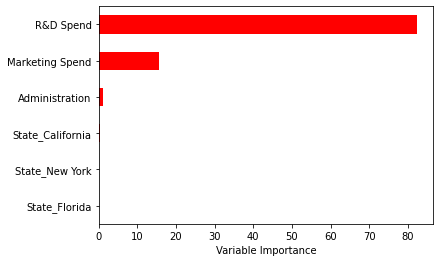

In [ ]:
# Modelimiz Değişkenlerin Ağılıklarını Öğrendiğine GÖre Soralım Bakalım En Çok Getiri Sağlayan Yatırım Ne imiş ?
from matplotlib import pyplot as plt
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},index=X_train.columns)
Importance.sort_values(by="Importance",axis=0,ascending=True).plot(kind = "barh",color = "r")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None # Görünüşe göre Ar ge harcamaları gerçekten gelirimizi arttırıcak(Startupların Hepsinin Aynı Sektörde Olduğunu Kabul Edelim)
                         # Biz de sektöre yeni adım atmış genç bir girişimci olarak Ar Ge ye yatırım yapmamız gerektiğini anladık

In [ ]:
yeni_df =pd.DataFrame([200000.20,	100000.80,	350000.10,	1,	0,	0]) # Ben de Arge harcamalarına 200 000 dolar yatırım yapmaya karar verdim bakalım bu yıl ki Karım ne kadar olacak

In [ ]:
yeni_df.T

,0,1,2,3,4,5
0,200000.2,100000.8,350000.1,1.0,0.0,0.0


In [ ]:
rf_tuned.predict(yeni_df.T)  # Arge ye 200 000 dolarlık bir yatırımla bu yıl ki karım 171500 dolar olacakmış biraz daha farklı bir bütçe ayırmayı deneyelim

array([171500.6904])

In [ ]:
yeni_df =pd.DataFrame([300000.20,	150000.80,	350000.10,	1,	0,	0]) # ArGe ye bi sefer 300 000 dolar yatırım yaptım ama karımda pek bir değişiklik olmadığını gördüm 
rf_tuned.predict(yeni_df.T)                                           # Bu gereksiz harcamayı yapmayacağım. Neyse ki benim önümü aydınlatan bir veri bilimcim var :)

array([171669.38665])